## AI/ML Model Training for Simulated Data

In [2]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
df = pd.read_csv("../dataset/simulation_data_20250627_091821.csv")

# Print top 5 rows of the dataset
df.head()

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-06-27 | 00:00:00,30.79,73.36,0.23,0.05,0.0,-57.38
1,2025-06-27 | 00:01:00,30.86,73.53,0.31,0.05,0.0,-55.36
2,2025-06-27 | 00:02:00,30.96,73.70,0.25,0.05,0.0,-58.61
3,2025-06-27 | 00:03:00,31.06,73.87,0.28,0.05,0.0,-61.92
4,2025-06-27 | 00:04:00,31.17,74.04,0.25,0.05,0.0,-59.46


### Data Preprocessing

In [4]:
# Convert timestamp into datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Set timestamp as index
df.set_index("timestamp", inplace=True)

# Check for missing values
df.isnull().sum()

temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64

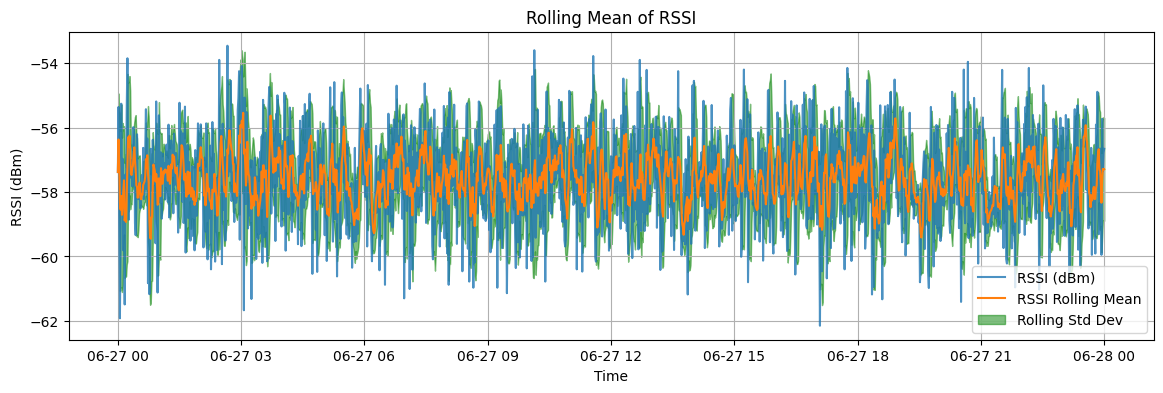

In [5]:
# Create rolling mean for rssi
df["rssi_rolling_mean"] = df["rssi(dBm)"].rolling(window=5, min_periods=1).mean()
df["rssi_rolling_std"] = df["rssi(dBm)"].rolling(window=5, min_periods=1).std()

# Plot the rolling mean of rssi and latency
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["rssi(dBm)"], label="RSSI (dBm)", alpha=0.8)
plt.plot(df.index, df["rssi_rolling_mean"], label="RSSI Rolling Mean")
plt.fill_between(df.index, df["rssi_rolling_mean"] - df["rssi_rolling_std"], 
                df["rssi_rolling_mean"] + df["rssi_rolling_std"], color='green', alpha=0.5, label="Rolling Std Dev")
plt.title("Rolling Mean of RSSI")
plt.xlabel("Time")
plt.ylabel("RSSI (dBm)")
plt.legend()
plt.grid()
plt.show()

### Data Visualization

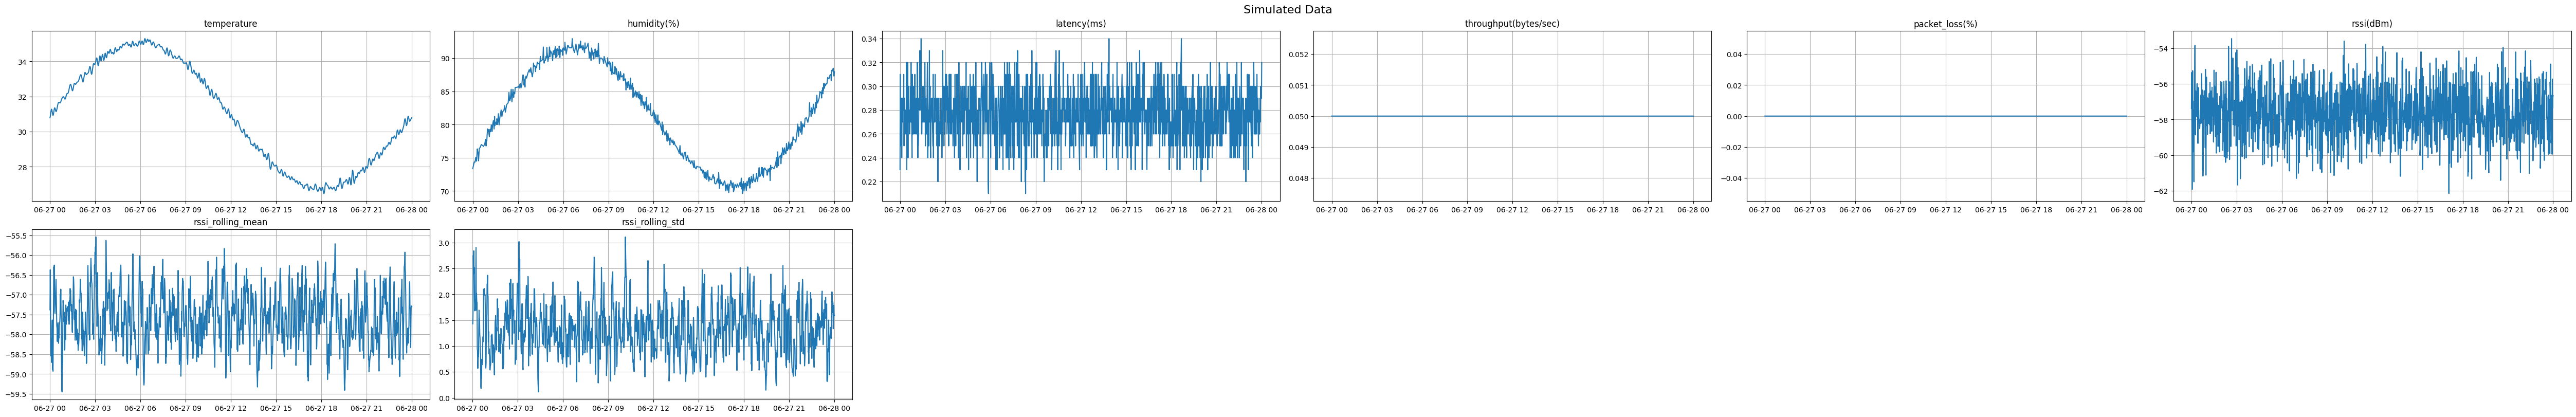

In [6]:
# Define num of rows and columns for the subplots
num_cols = 6
num_rows = int(np.ceil(len(df.columns) / num_cols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 8), constrained_layout=True)

# Flatten the axes array for iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(df.columns):
  axes[i].plot(df[column])
  axes[i].set_title(column)
  axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

# Set the overall title for the figure
fig.suptitle("Simulated Data", fontsize=16)
plt.show()

### Model Training

In [7]:
# Define features and target variable
X = df.drop(columns=["rssi(dBm)", "throughput(bytes/sec)", "packet_loss(%)"], axis=1)
y = df["rssi(dBm)"]

# Combine all data
full_data = pd.concat([X, y], axis=1)
full_data = full_data.dropna()

# Split into features and target variable again
X = full_data
y = full_data["rssi(dBm)"]

# Scale the data using MinMaxScaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scalers
X_scaled = feature_scaler.fit_transform(X)

# Convert 1D to 2D array, which -1 means "as many rows as needed and 1 means one column
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, y_scaled, test_size=0.2,
  shuffle=False
)

In [8]:
# Train LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam

# Model building
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(LSTM(units=100, return_sequences=False))
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(Dense(units=1))  # Output layer for regression

# Define optimizer
adam = Adam(learning_rate=0.001) 

# Compile the model
model_lstm.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])
model_lstm.summary()

c:\Project\iot-network-digital-twin\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
  monitor='val_loss', # Monitor validation loss
  patience=10, # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history_lstm = model_lstm.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for RNN input
  y_train.reshape(-1, 1), # Reshape y_train for RNN input
  epochs=100,
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for RNN input
    y_test.reshape(-1, 1) # Reshape y_test for RNN input
  ),
  verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.1127 - mse: 0.1127 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

### Model Predict

In [10]:
# Predict on the test set
predictions_lstm = model_lstm.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


In [11]:
# Print the error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(y_test_unscaled, predictions_lstm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions_lstm)
r2 = r2_score(y_test_unscaled, predictions_lstm)
mape = mean_absolute_percentage_error(y_test_unscaled, predictions_lstm)

# Print the error metrics
model_performance = pd.DataFrame({
  "Model": "LSTM",
  "MSE": mse,
  "RMSE": rmse,
  "MAE": mae,
  "R2": r2,
  "MAPE": mape
}, index=[0])

model_performance.set_index("Model", inplace=True)
model_performance

,MSE,RMSE,MAE,R2,MAPE
Model,,,,,
LSTM,0.000443,0.021057,0.016002,0.999772,0.000279


### Plot Predicted and Actual Data

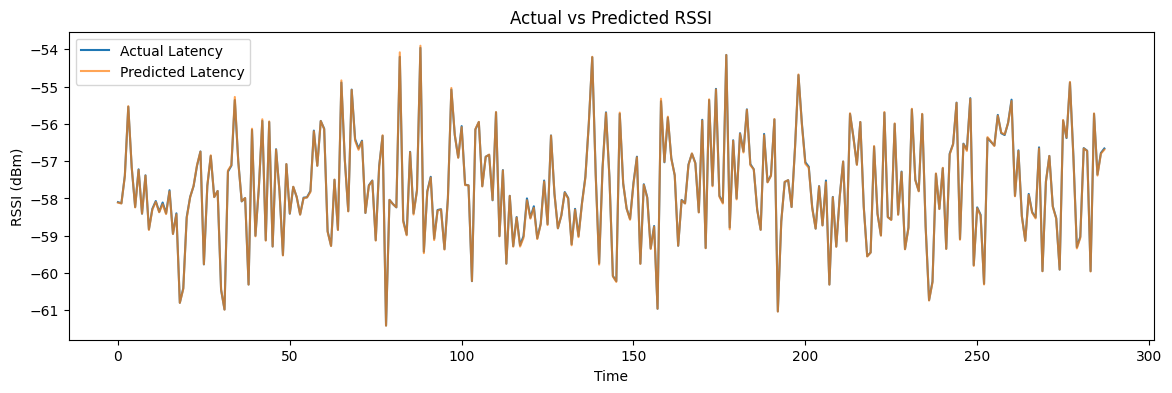

In [12]:
# Visualize the predictions for LSTM model
plt.figure(figsize=(14, 4))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_lstm, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted RSSI")
plt.xlabel("Time")
plt.ylabel("RSSI (dBm)")
plt.legend()
plt.show()

In [13]:
# Export model
from tensorflow.keras.models import save_model

save_model(model_lstm, "../model/lstm_model_simulated.h5")